In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Устройство:", device)


Устройство: cuda


In [3]:
import pandas as pd

df = pd.read_csv("/kaggle/input/aptos2019-blindness-detection/train.csv")
df.head()


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),      
    transforms.ToTensor(),               
    transforms.Normalize([0.5], [0.5])   
])


In [5]:
class RetinaDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = f"{self.image_dir}/{row['id_code']}.png"
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        label = int(row['diagnosis'])
        return image, label


In [6]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)

image_dir = "/kaggle/input/aptos2019-blindness-detection/train_images"

train_dataset = RetinaDataset(train_df, image_dir, transform=transform)
val_dataset = RetinaDataset(val_df, image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [7]:
images, labels = next(iter(train_loader))
print(f"Форма батча изображений: {images.shape}")
print(f"Метки классов: {labels}")


Форма батча изображений: torch.Size([16, 3, 224, 224])
Метки классов: tensor([1, 0, 0, 2, 2, 1, 2, 0, 0, 2, 3, 0, 0, 0, 1, 2])


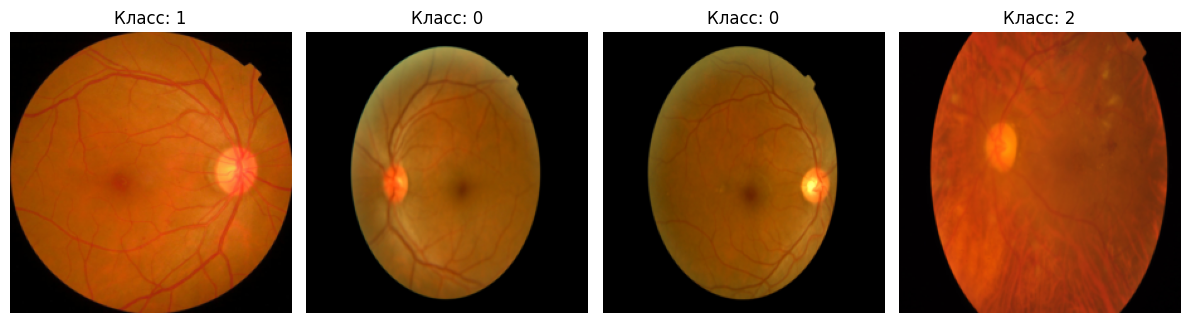

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def denormalize(tensor):
    return tensor * 0.5 + 0.5

plt.figure(figsize=(12, 4))
for i in range(4):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()  # HWC
    label = labels[i].item()
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Класс: {label}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [9]:
model = models.resnet18(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
num_epochs = 10  
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    print(f"epoch [{epoch+1}/{num_epochs}] — loss: {epoch_loss:.4f}, acc: {epoch_acc:.2f}%")

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), "/kaggle/working/resnet18_best.pth")
        print("model saved: resnet18_best.pth ✅")

torch.save(model.state_dict(), "/kaggle/working/resnet18_final.pth")
print(f"\n: best accuracy is{best_acc:.2f}%")
print("final version saved as resnet18_final.pth")

from IPython.display import FileLink
FileLink(r'/kaggle/working/resnet18_final.pth')


epoch [1/10] — loss: 0.7781, acc: 72.07%
model saved: resnet18_best.pth ✅
epoch [2/10] — loss: 0.6358, acc: 76.72%
model saved: resnet18_best.pth ✅
epoch [3/10] — loss: 0.5714, acc: 78.39%
model saved: resnet18_best.pth ✅
epoch [4/10] — loss: 0.5467, acc: 80.68%
model saved: resnet18_best.pth ✅
epoch [5/10] — loss: 0.5128, acc: 80.78%
model saved: resnet18_best.pth ✅
epoch [6/10] — loss: 0.4611, acc: 83.03%
model saved: resnet18_best.pth ✅
epoch [7/10] — loss: 0.4274, acc: 83.03%
epoch [8/10] — loss: 0.4168, acc: 84.09%
model saved: resnet18_best.pth ✅
epoch [9/10] — loss: 0.3388, acc: 87.71%
model saved: resnet18_best.pth ✅
epoch [10/10] — loss: 0.3452, acc: 88.80%
model saved: resnet18_best.pth ✅

: best accuracy is88.80%
final version saved as resnet18_final.pth


/kaggle/working/resnet18_final.pth

In [12]:
model.load_state_dict(torch.load("/kaggle/working/resnet18_best.pth"))
model.eval()

val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_loss /= len(val_loader)
val_acc = 100. * correct / total

print(f"\n Validation Loss: {val_loss:.4f}")
print(f" Validation Accuracy: {val_acc:.2f}%")


/tmp/ipykernel_19/2794205411.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/resnet18_best.pth"))



 Validation Loss: 0.6769
 Validation Accuracy: 77.63%


In [13]:
model.load_state_dict(torch.load("/kaggle/input/normal/pytorch/default/1/resnet18_best.pth"))
model.to(device)


/tmp/ipykernel_19/1068421306.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/normal/pytorch/default/1/resnet18_best.pth")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
strong_train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [15]:
train_dataset = RetinaDataset(train_df, image_dir, transform=strong_train_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [16]:
num_epochs = 5
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    print(f"Эпоха [{epoch+1}/{num_epochs}] — Потери: {epoch_loss:.4f}, Точность: {epoch_acc:.2f}%")

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), "/kaggle/working/resnet18_boosted_aug.pth")
        print("boosted model saved")

print(f"\n best accuracy is: {best_acc:.2f}%")


Эпоха [1/5] — Потери: 0.7185, Точность: 73.85%
boosted model saved
Эпоха [2/5] — Потери: 0.6454, Точность: 75.35%
boosted model saved
Эпоха [3/5] — Потери: 0.6061, Точность: 77.53%
boosted model saved
Эпоха [4/5] — Потери: 0.5779, Точность: 78.59%
boosted model saved
Эпоха [5/5] — Потери: 0.5668, Точность: 78.93%
boosted model saved

 best accuracy is: 78.93%


In [17]:
torch.save(model.state_dict(), "/kaggle/working/resnet18_boosted_aug_v2.pth")


In [18]:
num_epochs = 10
best_acc = 0.0  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\n epoch {epoch + 1}/{num_epochs} started")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx % 30 == 0:
            print(f"   batch {batch_idx}, current loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    print(f" epoch [{epoch+1}/{num_epochs}] — loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.2f}%")

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), "/kaggle/working/resnet18_boosted_aug_v2.pth")
        print("boosted model v2 is saved")

print(f"\n done! best accuracy is: {best_acc:.2f}%")



 epoch 1/10 started
   batch 0, current loss: 0.4638
   batch 30, current loss: 0.4287
   batch 60, current loss: 0.5952
   batch 90, current loss: 1.0557
   batch 120, current loss: 0.6718
   batch 150, current loss: 1.1689
   batch 180, current loss: 0.2459
 epoch [1/10] — loss: 0.5569, accuracy: 78.18%
boosted model v2 is saved

 epoch 2/10 started
   batch 0, current loss: 0.6630
   batch 30, current loss: 0.6054
   batch 60, current loss: 0.4673
   batch 90, current loss: 0.7486
   batch 120, current loss: 0.7054
   batch 150, current loss: 0.2954
   batch 180, current loss: 0.3595
 epoch [2/10] — loss: 0.5571, accuracy: 78.93%
boosted model v2 is saved

 epoch 3/10 started
   batch 0, current loss: 0.3359
   batch 30, current loss: 0.7396
   batch 60, current loss: 0.7199
   batch 90, current loss: 0.6792
   batch 120, current loss: 0.3753
   batch 150, current loss: 0.5560
   batch 180, current loss: 0.3906
 epoch [3/10] — loss: 0.5476, accuracy: 80.27%
boosted model v2 is save

In [19]:
model.load_state_dict(torch.load("/kaggle/working/resnet18_boosted_aug_v2.pth"))
model.to(device)
model.eval()

val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_loss /= len(val_loader)
val_acc = 100. * correct / total

print(f"\n Validation Loss: {val_loss:.4f}")
print(f" Validation Accuracy: {val_acc:.2f}%")


/tmp/ipykernel_19/1870928985.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/resnet18_boosted_aug_v2.pth"))



 Validation Loss: 0.5195
 Validation Accuracy: 81.17%


/tmp/ipykernel_19/562629686.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/resnet18_boosted_aug_v2.pth"))


<Figure size 600x600 with 0 Axes>

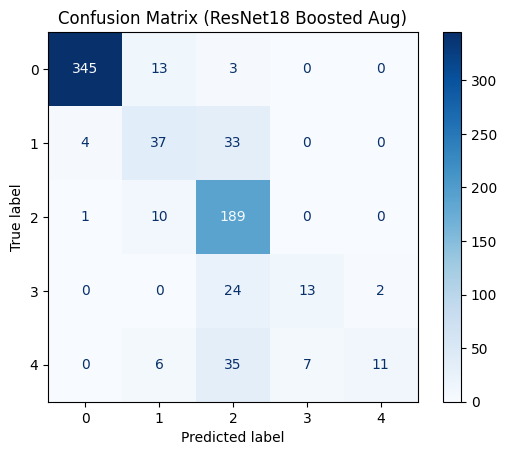

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.load_state_dict(torch.load("/kaggle/working/resnet18_boosted_aug_v2.pth"))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (ResNet18 Boosted Aug)")
plt.show()


/tmp/ipykernel_19/3997519526.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/normal/pytorch/default/1/resnet18_best.pth")

<Figure size 600x600 with 0 Axes>

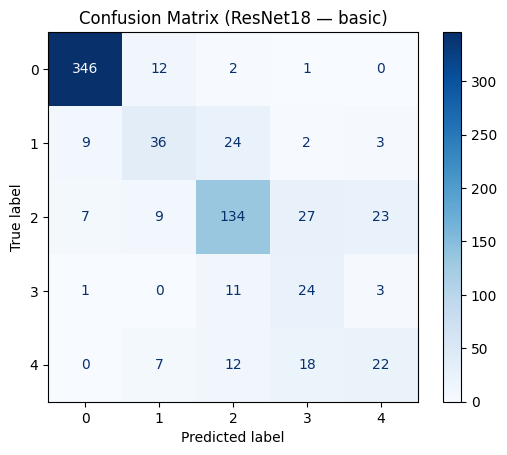

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.load_state_dict(torch.load("/kaggle/input/normal/pytorch/default/1/resnet18_best.pth"))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (ResNet18 — basic)")
plt.show()


In [22]:
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

stronger_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=15, shear=10),
    transforms.ToTensor(), 
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = RetinaDataset(train_df, image_dir, transform=stronger_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

model.load_state_dict(torch.load("/kaggle/working/resnet18_boosted_aug_v2.pth"))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

num_epochs = 5
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\n epoch {epoch + 1}/{num_epochs} started")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx % 30 == 0:
            print(f"  batch {batch_idx}, loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    print(f"epoch [{epoch+1}/{num_epochs}] — loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.2f}%")

    scheduler.step(epoch_acc)

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), "/kaggle/working/resnet18_final_maxboost.pth")
        print("upgraded version saved")

print(f"\n best accuracy: {best_acc:.2f}%")


/tmp/ipykernel_19/1412924636.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/resnet18_boosted_aug_v2.pth"))
/usr/local


 epoch 1/5 started
  batch 0, loss: 0.4002
  batch 30, loss: 0.6505
  batch 60, loss: 0.5568
  batch 90, loss: 0.6104
  batch 120, loss: 0.6169
  batch 150, loss: 0.3381
  batch 180, loss: 0.4220
epoch [1/5] — loss: 0.4882, accuracy: 81.84%
upgraded version saved

 epoch 2/5 started
  batch 0, loss: 0.6673
  batch 30, loss: 0.4161
  batch 60, loss: 0.6760
  batch 90, loss: 0.7780
  batch 120, loss: 0.3027
  batch 150, loss: 0.6586
  batch 180, loss: 0.2123
epoch [2/5] — loss: 0.4768, accuracy: 81.80%

 epoch 3/5 started
  batch 0, loss: 0.3575
  batch 30, loss: 0.3048
  batch 60, loss: 0.1893
  batch 90, loss: 0.3454
  batch 120, loss: 0.3837
  batch 150, loss: 0.6112
  batch 180, loss: 0.4794
epoch [3/5] — loss: 0.4644, accuracy: 83.10%
upgraded version saved

 epoch 4/5 started
  batch 0, loss: 0.4639
  batch 30, loss: 0.5246
  batch 60, loss: 0.2768
  batch 90, loss: 0.2952
  batch 120, loss: 0.6930
  batch 150, loss: 0.3401
  batch 180, loss: 0.2721
epoch [4/5] — loss: 0.4568, acc